# Feature Scaling and Normalization - Lab

## Introduction
In this lab, you'll practice your feature scaling and normalization skills!

## Objectives
You will be able to:
* Identify if it is necessary to perform log transformations on a set of features
* Perform log transformations on different features of a dataset
* Determine if it is necessary to perform normalization/standardization for a specific model or set of data
* Compare the different standardization and normalization techniques
* Use standardization/normalization on features of a dataset

## Back to the Ames Housing data

Let's import our Ames Housing data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

ames = pd.read_csv('ames.csv')

## Look at the histograms for the continuous variables

Since there are so many features it is helpful to filter the columns by datatype and number of unique values. A heuristic you might use to select continous variables might be a combination of features that are not object datatypes and have at least a certain amount of unique values.

In [8]:
cont_data = ames.loc[:, ((ames.dtypes != 'object') & (ames.nunique() > 20))]
cont_data.head()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,SalePrice
0,1,65.0,8450,2003,2003,196.0,706,0,150,856,...,0,1710,2003.0,548,0,61,0,0,0,208500
1,2,80.0,9600,1976,1976,0.0,978,0,284,1262,...,0,1262,1976.0,460,298,0,0,0,0,181500
2,3,68.0,11250,2001,2002,162.0,486,0,434,920,...,0,1786,2001.0,608,0,42,0,0,0,223500
3,4,60.0,9550,1915,1970,0.0,216,0,540,756,...,0,1717,1998.0,642,0,35,272,0,0,140000
4,5,84.0,14260,2000,2000,350.0,655,0,490,1145,...,0,2198,2000.0,836,192,84,0,0,0,250000


In [9]:
cont_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   YearBuilt      1460 non-null   int64  
 4   YearRemodAdd   1460 non-null   int64  
 5   MasVnrArea     1452 non-null   float64
 6   BsmtFinSF1     1460 non-null   int64  
 7   BsmtFinSF2     1460 non-null   int64  
 8   BsmtUnfSF      1460 non-null   int64  
 9   TotalBsmtSF    1460 non-null   int64  
 10  1stFlrSF       1460 non-null   int64  
 11  2ndFlrSF       1460 non-null   int64  
 12  LowQualFinSF   1460 non-null   int64  
 13  GrLivArea      1460 non-null   int64  
 14  GarageYrBlt    1379 non-null   float64
 15  GarageArea     1460 non-null   int64  
 16  WoodDeckSF     1460 non-null   int64  
 17  OpenPorchSF    1460 non-null   int64  
 18  Enclosed

In [10]:
cont_data.shape # has 1460 rows and 22 cols as indicated by .info()
# can slice this output

(1460, 22)

In [11]:
cont_vars = [col for col in cont_data if col != 'Id']
cont_vars

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'MiscVal',
 'SalePrice']

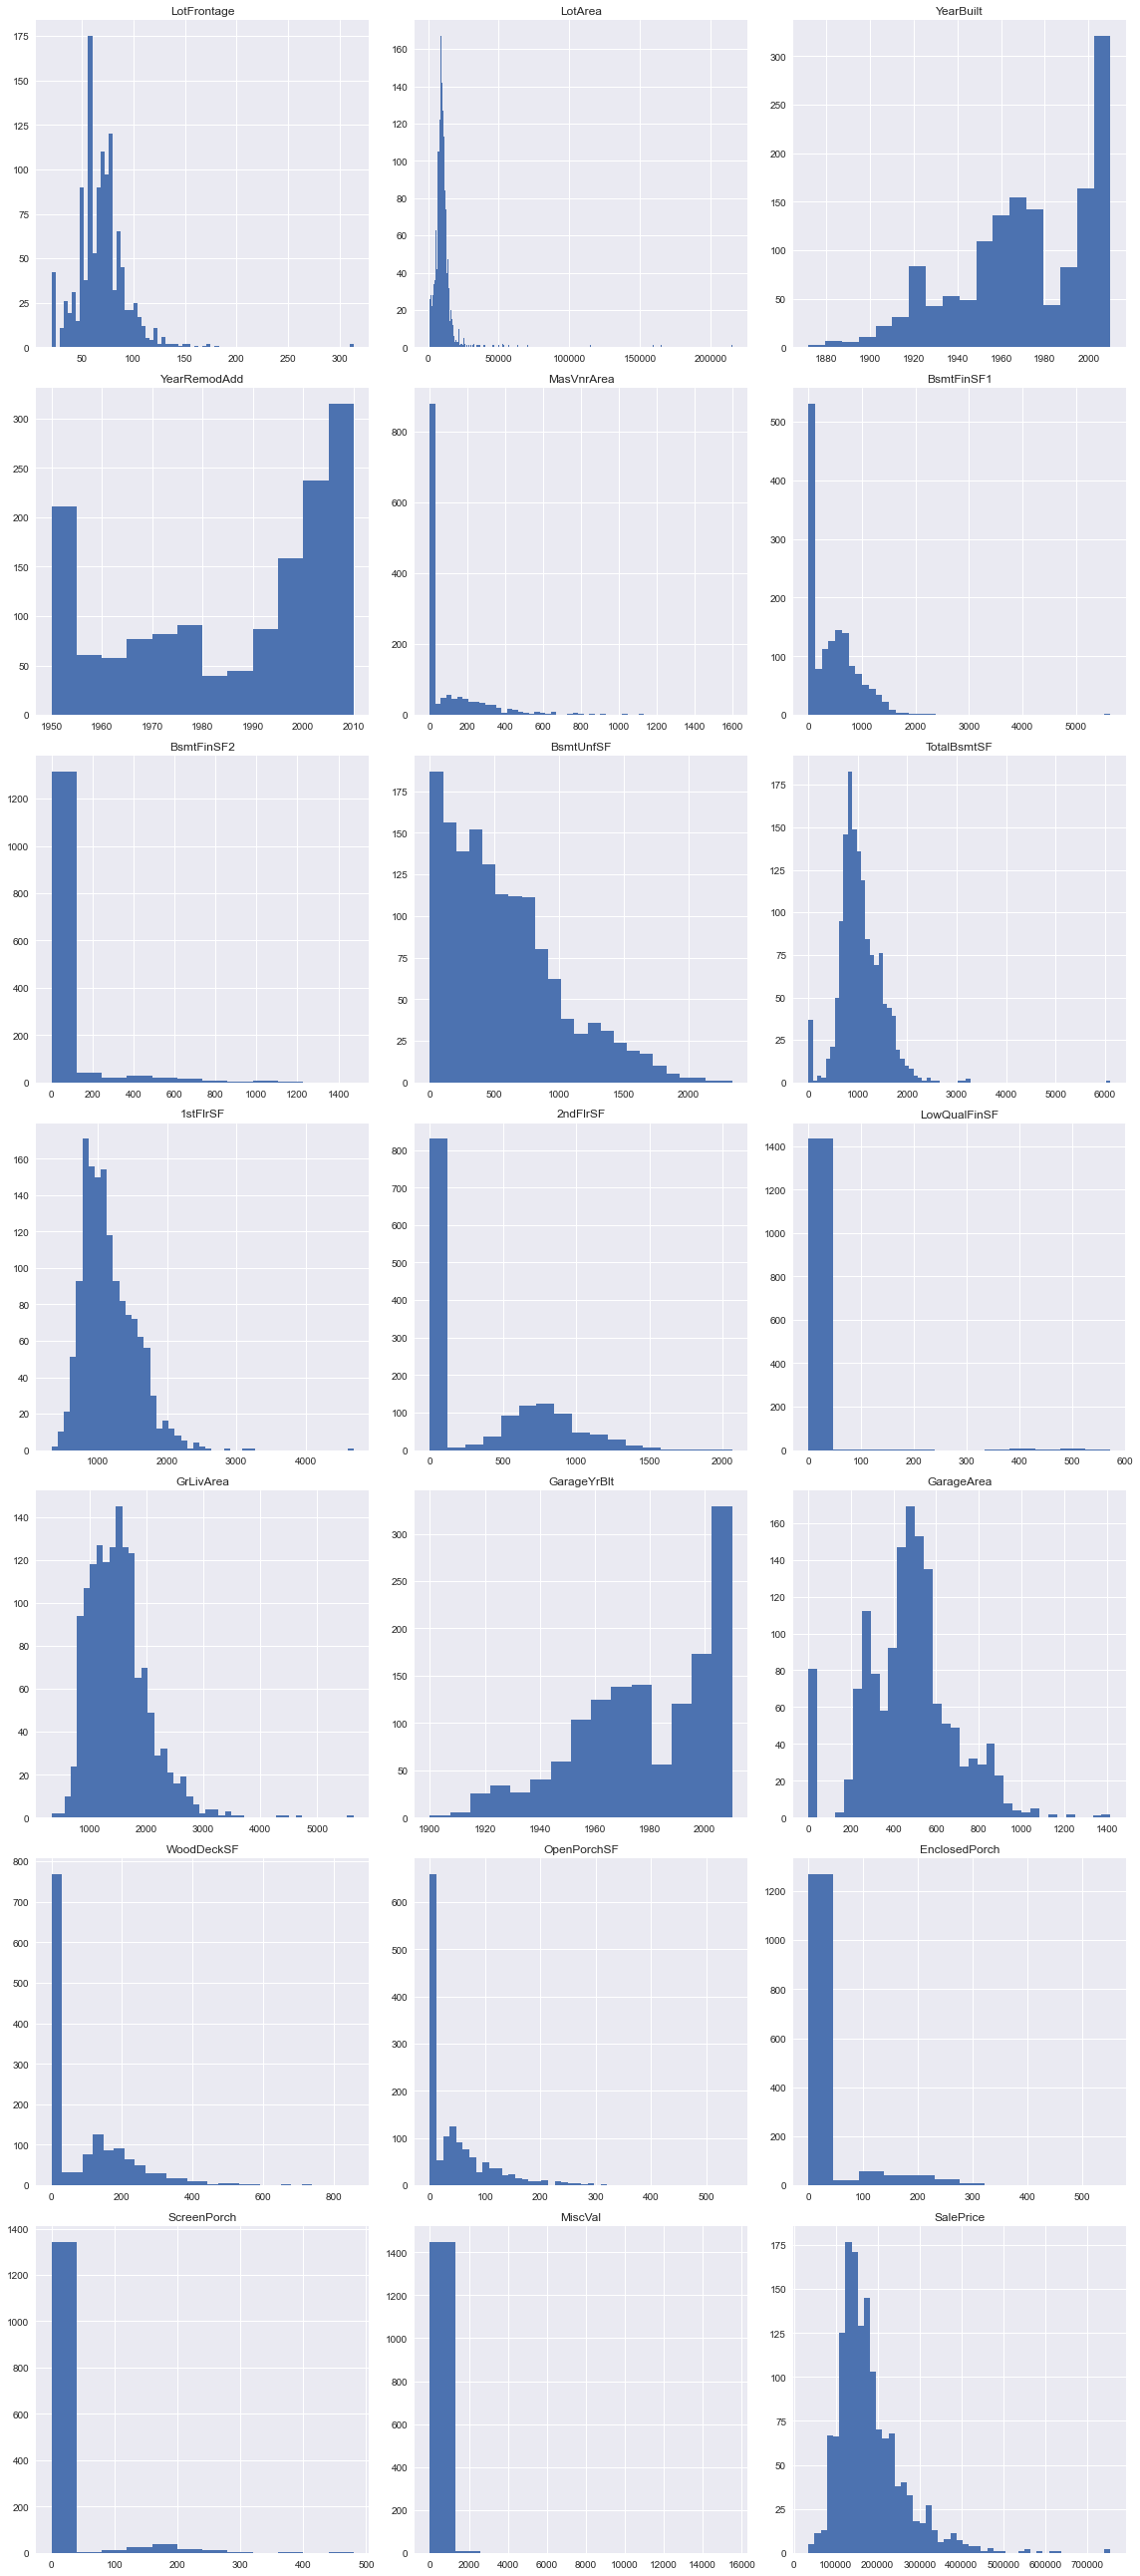

In [13]:
fig, axes = plt.subplots(nrows=cont_data.shape[1] // 3, # floor division of num of cols by 3 to fit into 3 cols
                         ncols=3,
                         figsize=(16,36))

for var, ax in zip(cont_vars, axes.flatten()):
    ax.hist(ames[var].dropna(), bins='auto')
    ax.set_title(var)
    
fig.tight_layout()

We can see from our histograms of the continuous features that there are many examples where there are a ton of zeros. For example, WoodDeckSF (square footage of a wood deck) gives us a positive number indicating the size of the deck and zero if no deck exists. It might have made sense to categorize this variable to "deck exists or not (binary variable 1/0). Now you have a zero-inflated variable which is cumbersome to work with.

Lets drop these zero-inflated variables for now and select the features which don't have this characteristic.

In [19]:
cont_data['WoodDeckSF'].value_counts()[0] # there are 761 entries of 0 in the WoodDeckSF col

761

In [20]:
(cont_data['WoodDeckSF'].value_counts()[0] / len(cont_data)) * 100 # which is 52% of the col

52.12328767123287

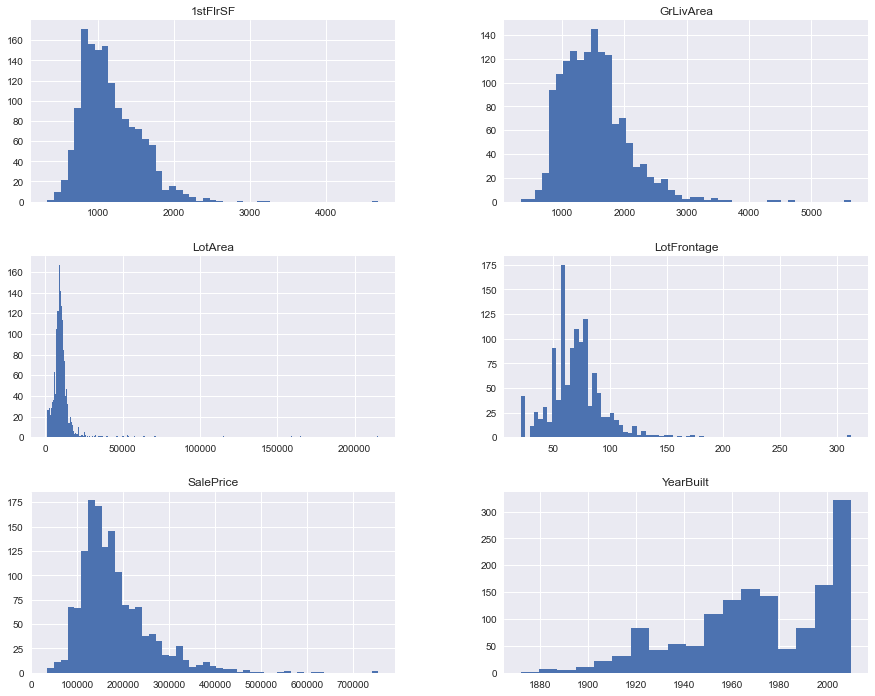

In [28]:
# Select non zero-inflated continuous features as ames_cont
continuous = ['LotFrontage', 'LotArea', 'YearBuilt', '1stFlrSF', 'GrLivArea', 'SalePrice']
ames_cont = ames[continuous]
ames_cont.hist(figsize=(15,12), bins='auto');

## Perform log transformations for the variables where it makes sense

In [32]:
import numpy as np

# make a list of names for cols after log transformation
log_names = [f'{col}_log' for col in ames_cont.columns]

# log transform the cols and store in new df
ames_log = np.log(ames_cont)
# rename the cols in the new df to reflect that they have been log transformed
ames_log.columns = log_names
ames_log.head()

,LotFrontage_log,LotArea_log,YearBuilt_log,1stFlrSF_log,GrLivArea_log,SalePrice_log
0,4.174387,9.041922,7.602401,6.752270,7.444249,12.247694
1,4.382027,9.169518,7.588830,7.140453,7.140453,12.109011
2,4.219508,9.328123,7.601402,6.824374,7.487734,12.317167
3,4.094345,9.164296,7.557473,6.867974,7.448334,11.849398
4,4.430817,9.565214,7.600902,7.043160,7.695303,12.429216


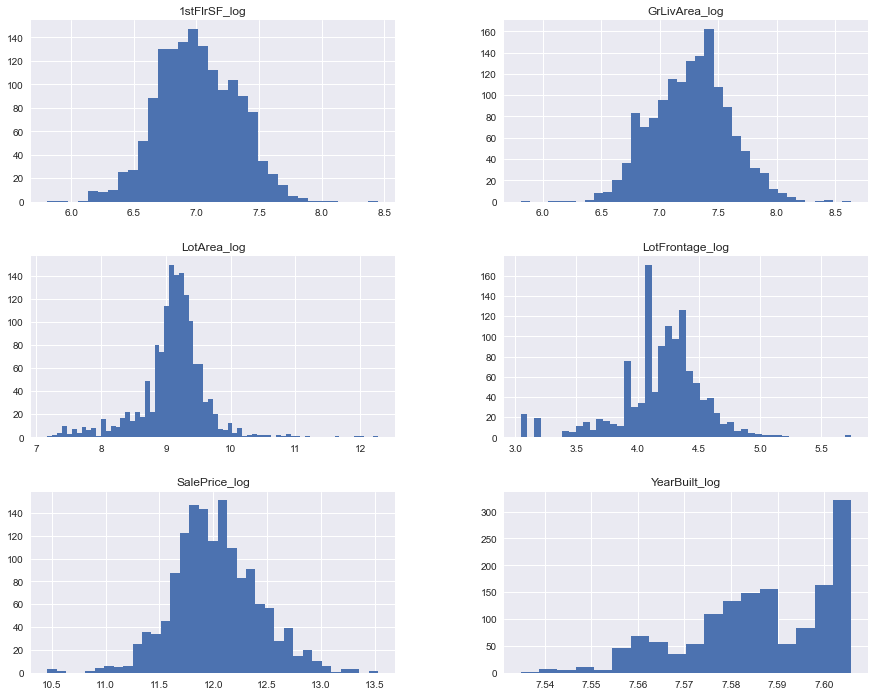

In [33]:
ames_log.hist(figsize=(15,12), bins='auto');

In [ ]:
# note that log transformation helped reduce skew in all variables EXCEPT year built

## Standardize the continuous variables

Store your final features in a DataFrame `features_final`: 

In [35]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

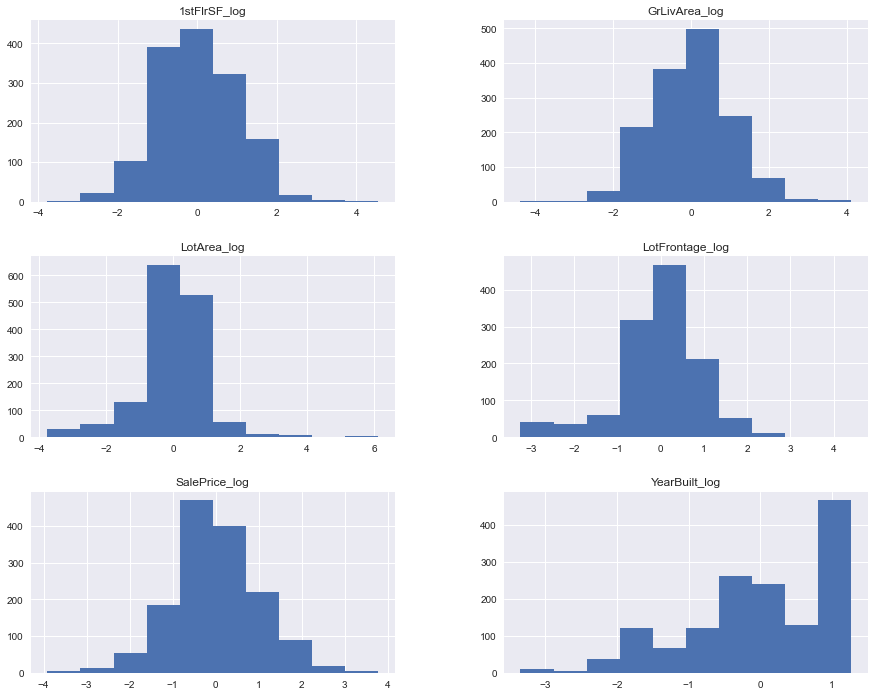

In [36]:
features_final = ames_log.apply(normalize)

features_final.hist(figsize=(15,12));

## Summary
Great! You've now got some hands-on practice transforming data using log transforms, feature scaling, and normalization!